## Libraries

In [1]:
import abc
import codecs
import inspect
import json
import logging
import gc
import os
import pickle
import random
import sys
import time
import warnings

import catboost as cat
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from abc import abstractmethod
from contextlib import contextmanager
from pathlib import Path
from typing import List, Optional, Union, Tuple, Dict, Sequence

from catboost import CatBoostClassifier, CatBoostRegressor
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm_notebook

## Config

In [2]:
cat_conf_string = '''
dataset:
  dir: "../input/data-science-bowl-2019/"
  feature_dir: "../features"
  params:

features:
  - UnifiedWithInstallationIDStats

av:
  split_params:
    random_state: 42
    n_splits: 5

  model_params:
    objective: "binary"
    metric: "auc"
    boosting: "gbdt"
    max_depth: 7
    num_leaves: 75
    learning_rate: 0.01
    colsample_bytree: 0.7
    subsample: 0.1
    subsample_freq: 1
    seed: 111
    feature_fraction_seed: 111
    drop_seed: 111
    verbose: -1
    n_jobs: -1
    first_metric_only: True

  train_params:
    num_boost_round: 50000
    early_stopping_rounds: 100
    verbose_eval: 100

model:
  name: "catboost"
  mode: "regression"
  sampling:
    name: "none"
    params:
      k_neighbors: 7
      n_jobs: 4
      random_state: 42
      acc_0_coef: 1.0
      acc_1_coef: 1.0
      acc_2_coef: 1.0
      acc_3_coef: 1.0

  model_params:
    loss_function: "RMSE"
    task_type: "CPU"
    iterations: 6000
    early_stopping_rounds: 100
    random_seed: 42

  train_params:
    mode: "regression"
    
post_process:
  params:
    reverse: False
    n_overall: 20
    n_classwise: 20

val:
  name: "group_kfold"
  params:
    n_splits: 5
    random_state: 111

output_dir: "output"
'''


lgb_conf_string = '''
dataset:
  dir: "../input/data-science-bowl-2019/"
  feature_dir: "../features"
  params:

features:
  - UnifiedWithInstallationIDStats

av:
  split_params:
    random_state: 42
    n_splits: 5

  model_params:
    objective: "binary"
    metric: "auc"
    boosting: "gbdt"
    max_depth: 7
    num_leaves: 75
    learning_rate: 0.01
    colsample_bytree: 0.7
    subsample: 0.1
    subsample_freq: 1
    seed: 111
    feature_fraction_seed: 111
    drop_seed: 111
    verbose: -1
    first_metric_only: True

  train_params:
    num_boost_round: 50000
    early_stopping_rounds: 100
    verbose_eval: 100

model:
  name: "lgbm"
  mode: "regression"
  sampling:
    name: "none"
    params:
      k_neighbors: 7
      n_jobs: 4
      random_state: 42
      acc_0_coef: 1.0
      acc_1_coef: 1.0
      acc_2_coef: 1.0
      acc_3_coef: 1.0

  model_params:
    objective: "regression"
    metric: "rmse"
    boosting_type: "gbdt"
    max_depth: -1
    num_leaves: 256
    tree_learner: "serial"
    learning_rate: 0.01
    subsample: 0.7
    subsample_freq: 1
    colsample_bytree: 0.5
    max_bin: 255
    seed: 71
    bagging_seed: 71
    feature_fraction_seed: 71
    drop_seed: 71
    verbose: -1
    n_jobs: -1
    first_metric_only: False

  train_params:
    num_boost_round: 10000
    early_stopping_rounds: 100
    verbose_eval: 100
    
post_process:
  params:
    reverse: False
    n_overall: 20
    n_classwise: 20

val:
  name: "group_kfold"
  params:
    n_splits: 5
    random_state: 222

output_dir: "output"
'''

In [3]:
cat_config = dict(yaml.load(cat_conf_string, Loader=yaml.SafeLoader))
lgb_config = dict(yaml.load(lgb_conf_string, Loader=yaml.SafeLoader))

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
    
seed_everything(42)

## Functions and Classes

### utils

#### checker

In [5]:
def feature_existence_checker(feature_path: Path,
                              feature_names: List[str]) -> bool:
    features = [f.name for f in feature_path.glob("*.ftr")]
    for f in feature_names:
        if f + "_train.ftr" not in features:
            return False
        if f + "_valid.ftr" not in features:
            return False
        if f + "_test.ftr" not in features:
            return False
    return True

#### jsonutil

In [6]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def save_json(config: dict, save_path: Union[str, Path]):
    f = codecs.open(str(save_path), mode="w", encoding="utf-8")
    json.dump(config, f, indent=4, cls=MyEncoder, ensure_ascii=False)
    f.close()

#### logger

In [7]:
def configure_logger(config_name: str, log_dir: Union[Path, str], debug: bool):
    if isinstance(log_dir, str):
        Path(log_dir).mkdir(parents=True, exist_ok=True)
    else:
        log_dir.mkdir(parents=True, exist_ok=True)

    log_filename = config_name.split("/")[-1].replace(".yml", ".log")
    log_filepath = log_dir / log_filename \
        if isinstance(log_dir, Path) else Path(log_dir) / log_filename

    # delete the old log
    if log_filepath.exists():
        with open(log_filepath, mode="w"):
            pass

    level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(
        filename=str(log_filepath),
        level=level,
        format="%(asctime)s %(levelname)s %(message)s",
        datefmt="%m/%d/%Y %I:%M:%S %p")

#### timer

In [8]:
@contextmanager
def timer(name: str, log: bool = False):
    t0 = time.time()
    msg = f"[{name}] start"
    if not log:
        print(msg)
    else:
        logging.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if not log:
        print(msg)
    else:
        logging.info(msg)

#### visualization

In [9]:
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          save_path: Path = Path("./")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, fontsize=25)
    plt.yticks(tick_marks, fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    plt.ylabel('True label', fontsize=25)
    plt.title(title, fontsize=30)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size="5%", pad=0.15)
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=20)

    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        #            title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                fontsize=20,
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(save_path)

### validation

In [10]:
def group_kfold(df: pd.DataFrame, groups: pd.Series,
                config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    params = config["val"]["params"]
    kf = KFold(
        n_splits=params["n_splits"],
        random_state=params["random_state"],
        shuffle=True)
    uniq_groups = groups.unique()
    split = []
    for trn_grp_idx, val_grp_idx in kf.split(uniq_groups):
        trn_grp = uniq_groups[trn_grp_idx]
        val_grp = uniq_groups[val_grp_idx]
        trn_idx = df[df["group"].isin(trn_grp)].index.values
        val_idx = df[df["group"].isin(val_grp)].index.values
        split.append((trn_idx, val_idx))

    return split


def get_validation(df: pd.DataFrame,
                   config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    name: str = config["val"]["name"]

    func = globals().get(name)
    if func is None:
        raise NotImplementedError

    if "group" in name:
        groups = df["group"]
        return func(df, groups, config)
    else:
        return func(df, config)

#### feature_selection

In [11]:
def select_features(cols: List[str], feature_importance: pd.DataFrame,
                    config: dict) -> List[str]:
    if config["val"].get("n_delete") is None:
        return cols

    n_delete = config["val"].get("n_delete")
    importance_sorted_cols = feature_importance.sort_values(
        by="value", ascending=False)["feature"].tolist()
    if isinstance(n_delete, int):
        remove_cols = importance_sorted_cols[:n_delete]
        for col in remove_cols:
            cols.remove(col)
    elif isinstance(n_delete, float):
        n_delete_int = int(n_delete * len(importance_sorted_cols))
        remove_cols = importance_sorted_cols[:n_delete_int]
        for col in remove_cols:
            cols.remove(col)
    return cols

### sampling

#### factory

In [12]:
def smote(x_trn: np.ndarray, y_trn: np.ndarray,
          config: dict) -> Tuple[np.ndarray, np.ndarray]:
    params = config["model"]["sampling"]["params"]
    sm = SMOTE(
        k_neighbors=params["k_neighbors"], random_state=params["random_state"])
    sampled_x, sampled_y = sm.fit_resample(x_trn, y_trn)
    return sampled_x, sampled_y


def random_under_sample(x_trn: np.ndarray, y_trn: np.ndarray,
                        config: dict) -> Tuple[np.ndarray, np.ndarray]:
    params = config["model"]["sampling"]["params"]
    acc_0 = (y_trn == 0).sum().astype(int)
    acc_1 = (y_trn == 1).sum().astype(int)
    acc_2 = (y_trn == 2).sum().astype(int)
    acc_3 = (y_trn == 3).sum().astype(int)
    rus = RandomUnderSampler({
        0: int(params["acc_0_coef"] * acc_0),
        1: int(params["acc_1_coef"] * acc_1),
        2: int(params["acc_2_coef"] * acc_2),
        3: int(params["acc_3_coef"] * acc_3)
    },
                             random_state=params["random_state"])
    sampled_x, sampled_y = rus.fit_resample(x_trn, y_trn)
    return sampled_x, sampled_y


def random_under_sample_and_smote(
        x_trn: np.ndarray, y_trn: np.ndarray,
        config: dict) -> Tuple[np.ndarray, np.ndarray]:
    sampled_x, sampled_y = random_under_sample(x_trn, y_trn, config)
    sampled_x, sampled_y = smote(sampled_x, sampled_y, config)
    return sampled_x, sampled_y


def get_sampling(x_trn: np.ndarray, y_trn: np.ndarray,
                 config: dict) -> Tuple[np.ndarray, np.ndarray]:
    if config["model"]["sampling"]["name"] == "none":
        return x_trn, y_trn

    policy = config["model"]["sampling"]["name"]
    func = globals().get(policy)
    if func is None:
        raise NotImplementedError
    return func(x_trn, y_trn, config)

### evaluation

#### metrics

In [13]:
def qwk(y_true: Union[np.ndarray, list],
        y_pred: Union[np.ndarray, list],
        max_rat: int = 3) -> float:
    y_true_ = np.asarray(y_true)
    y_pred_ = np.asarray(y_pred)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    uniq_class = np.unique(y_true_)
    for i in uniq_class:
        hist1[int(i)] = len(np.argwhere(y_true_ == i))
        hist2[int(i)] = len(np.argwhere(y_pred_ == i))

    numerator = np.square(y_true_ - y_pred_).sum()

    denominator = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            denominator += hist1[i] * hist2[j] * (i - j) * (i - j)

    denominator /= y_true_.shape[0]
    return 1 - numerator / denominator


def calc_metric(y_true: Union[np.ndarray, list],
                y_pred: Union[np.ndarray, list]) -> float:
    return qwk(y_true, y_pred)

#### optimization

In [14]:
class OptimizedRounder(object):
    def __init__(self,
                 n_overall: int = 5,
                 n_classwise: int = 5,
                 reverse: bool = False):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.coef = [0.25, 0.5, 0.75]
        self.reverse = reverse

    def _loss(self, X: np.ndarray, y: np.ndarray) -> float:
        X_p = np.digitize(X, self.coef)
        ll = -calc_metric(y, X_p)
        return ll

    def fit(self, X: np.ndarray, y: np.ndarray):
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(0.01, 0.4), (0.4, 0.7), (0.7, 0.9)]
        for _ in range(self.n_overall):
            if self.reverse:
                search = reversed(range(3))
            else:
                search = iter(range(3))
            for idx in search:
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                self.coef[idx] = a
                la = self._loss(X, y)
                self.coef[idx] = b
                lb = self._loss(X, y)
                for it in range(self.n_classwise):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        self.coef[idx] = a
                        la = self._loss(X, y)
                    else:
                        b = b - (b - a) * golden2
                        self.coef[idx] = b
                        lb = self._loss(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X_p = np.digitize(X, self.coef)
        return X_p

#### cat

In [15]:
class CatBoostOptimizedQWKMetric(object):
    def __init__(self,
                 n_overall: int = 5,
                 n_classwise: int = 5,
                 reverse: bool = False):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.reverse = reverse

    def get_final_error(self, error: float, weight: float) -> float:
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target,
                 weight: Optional[Sequence[float]]) -> Tuple[float, float]:
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]
        approx_np = np.array(approx)
        target_np = (np.array(target) * 3).astype(int)

        OptR = OptimizedRounder(
            n_classwise=self.n_classwise,
            n_overall=self.n_overall,
            reverse=self.reverse)
        OptR.fit(approx_np, target_np)

        y_pred = OptR.predict(approx_np).astype(int)
        y_true = target_np.astype(int)

        weight_sum = 1.0
        qwk = calc_metric(y_true, y_pred)
        return qwk, weight_sum

#### lgbm

In [16]:
def lgb_classification_qwk(y_pred: np.ndarray,
                           data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = data.get_label()
    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return "qwk", calc_metric(y_true, y_pred), True


def lgb_regression_qwk(y_pred: np.ndarray,
                       data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = (data.get_label() * 3).astype(int)
    y_pred = y_pred.reshape(-1)

    OptR = OptimizedRounder(n_classwise=5, n_overall=5)
    OptR.fit(y_pred, y_true)

    y_pred = OptR.predict(y_pred).astype(int)
    qwk = calc_metric(y_true, y_pred)

    return "qwk", qwk, True


def lgb_residual_qwk_closure(mean_target: np.ndarray):
    def lgb_residual_qwk(y_pred: np.ndarray,
                         data: lgb.Dataset) -> Tuple[str, float, bool]:
        y_true = (data.get_label() * 3).astype(int)
        y_pred = y_pred.reshape(-1)

        y_true = (y_true + mean_target).astype(int)
        y_pred = y_pred + mean_target

        OptR = OptimizedRounder(n_classwise=5, n_overall=5)
        OptR.fit(y_pred, y_true)

        y_pred = OptR.predict(y_pred).astype(int)
        qwk = calc_metric(y_true, y_pred)

        return "qwk", qwk, True

    return lgb_residual_qwk

### models

#### base

In [17]:
# type alias
AoD = Union[np.ndarray, pd.DataFrame]
AoS = Union[np.ndarray, pd.Series]
CatModel = Union[cat.CatBoostClassifier, cat.CatBoostRegressor]
LGBModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]
Model = Union[CatModel, LGBModel]


class BaseModel(object):
    @abstractmethod
    def fit(self, x_train: AoD, y_train: AoS, x_valid: AoD, y_valid: AoS,
            x_valid2: Optional[AoD], y_valid2: Optional[AoS],
            config: dict) -> Tuple[Model, dict]:
        raise NotImplementedError

    @abstractmethod
    def get_best_iteration(self, model: Model) -> int:
        raise NotImplementedError

    @abstractmethod
    def predict(self, model: Model, features: AoD) -> np.ndarray:
        raise NotImplementedError

    @abstractmethod
    def get_feature_importance(self, model: Model) -> np.ndarray:
        raise NotImplementedError

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     valid_preds: Optional[np.ndarray], y: np.ndarray,
                     y_valid: Optional[np.ndarray], config: dict
                     ) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        return oof_preds, test_preds, valid_preds

    def cv(self,
           y_train: AoS,
           train_features: AoD,
           test_features: AoD,
           y_valid: Optional[AoS],
           valid_features: Optional[AoD],
           feature_name: List[str],
           folds_ids: List[Tuple[np.ndarray, np.ndarray]],
           config: dict,
           log: bool = True
           ) -> Tuple[List[Model], np.ndarray, np.
                      ndarray, Optional[np.ndarray], pd.DataFrame, dict]:
        # initialize
        test_preds = np.zeros(len(test_features))
        oof_preds = np.zeros(len(train_features))
        if valid_features is not None:
            valid_preds = np.zeros(len(valid_features))
        else:
            valid_preds = None
        importances = pd.DataFrame(index=feature_name)
        best_iteration = 0.0
        cv_score_list: List[dict] = []
        models: List[Model] = []

        if config["model"]["mode"] == "residual":
            self.mean_targets: Dict[str, List[np.ndarray]] = {
                "train": [],
                "valid": [],
                "valid2": [valid_features["mean_target"].values],
                "test": [test_features["mean_target"].values]
            }
            valid_features.drop("mean_target", axis=1, inplace=True)
            test_features.drop("mean_target", axis=1, inplace=True)
            for t_idx, v_idx in folds_ids:
                self.mean_targets["train"].append(
                    train_features.loc[t_idx, "mean_target"].values)
                self.mean_targets["valid"].append(
                    train_features.loc[v_idx, "mean_target"].values)
            train_features.drop("mean_target", axis=1, inplace=True)
            feature_name.remove("mean_target")

        X = train_features.values if isinstance(train_features, pd.DataFrame) \
            else train_features
        y = y_train.values if isinstance(y_train, pd.Series) \
            else y_train

        X_valid = valid_features.values if isinstance(
            valid_features, pd.DataFrame) else valid_features
        y_valid = y_valid.values if isinstance(y_valid, pd.Series) \
            else y_valid

        for i_fold, (trn_idx, val_idx) in enumerate(folds_ids):
            self.fold = i_fold
            # get train data and valid data
            x_trn = X[trn_idx]
            y_trn = y[trn_idx]
            x_val = X[val_idx]
            y_val = y[val_idx]

            x_trn, y_trn = get_sampling(x_trn, y_trn, config)

            # train model
            model, best_score = self.fit(
                x_trn, y_trn, x_val, y_val, X_valid, y_valid, config=config)
            cv_score_list.append(best_score)
            models.append(model)
            best_iteration += self.get_best_iteration(model) / len(folds_ids)

            # predict oof and test
            oof_preds[val_idx] = self.predict(model, x_val).reshape(-1)
            test_preds += self.predict(
                model, test_features).reshape(-1) / len(folds_ids)

            if valid_features is not None:
                valid_preds += self.predict(
                    model, valid_features).reshape(-1) / len(folds_ids)

            if config["model"]["mode"] == "residual":
                oof_preds[val_idx] += self.mean_targets["valid"][self.fold]
                test_preds += self.mean_targets["test"][0]
                valid_preds += self.mean_targets["valid2"][0]

            # get feature importances
            importances_tmp = pd.DataFrame(
                self.get_feature_importance(model),
                columns=[f"gain_{i_fold+1}"],
                index=feature_name)
            importances = importances.join(importances_tmp, how="inner")

        # summary of feature importance
        feature_importance = importances.mean(axis=1)

        # save raw prediction
        self.raw_oof_preds = oof_preds
        self.raw_test_preds = test_preds
        self.raw_valid_preds = valid_preds

        # post_process (if you have any)
        oof_preds, test_preds, valid_preds = self.post_process(
            oof_preds, test_preds, valid_preds, y_train, y_valid, config)

        # print oof score
        oof_score = calc_metric(y_train, oof_preds)
        print(f"oof score: {oof_score:.5f}")
        if valid_features is not None:
            valid_score = calc_metric(y_valid, valid_preds)
            print(f"valid score: {valid_score:.5f}")

        if log:
            logging.info(f"oof score: {oof_score:.5f}")
            if valid_features is not None:
                logging.info(f"valid score: {valid_score:.5f}")

        evals_results = {
            "evals_result": {
                "oof_score":
                oof_score,
                "cv_score": {
                    f"cv{i + 1}": cv_score
                    for i, cv_score in enumerate(cv_score_list)
                },
                "n_data":
                len(train_features),
                "best_iteration":
                best_iteration,
                "n_features":
                len(train_features.columns),
                "feature_importance":
                feature_importance.sort_values(ascending=False).to_dict()
            }
        }

        if valid_features is not None:
            evals_results["valid_score"] = valid_score
        return (models, oof_preds, test_preds, valid_preds, feature_importance,
                evals_results)

#### cat

In [18]:
CatModel = Union[CatBoostClassifier, CatBoostRegressor]


class CatBoostModel(BaseModel):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            x_valid2: Optional[np.ndarray], y_valid2: Optional[np.ndarray],
            config: dict) -> Tuple[CatModel, dict]:
        model_params = config["model"]["model_params"]
        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            model = CatBoostRegressor(
                eval_metric=CatBoostOptimizedQWKMetric(
                    reverse=config["post_process"]["params"]["reverse"]),
                **model_params)
            self.denominator = y_train.max()
            y_train = y_train / y_train.max()
            y_valid = y_valid / self.denominator
            if y_valid2 is not None:
                y_valid2 = y_valid2 / self.denominator
        else:
            model = CatBoostClassifier(**model_params)

        if x_valid2 is not None:
            eval_sets = [(x_valid2, y_valid2)]
        else:
            eval_sets = [(x_valid, y_valid)]

        model.fit(
            x_train,
            y_train,
            eval_set=eval_sets,
            use_best_model=True,
            verbose=model_params["early_stopping_rounds"])
        best_score = model.best_score_
        return model, best_score

    def get_best_iteration(self, model: CatModel):
        return model.best_iteration_

    def predict(self, model: CatModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        return model.predict(features)

    def get_feature_importance(self, model: CatModel) -> np.ndarray:
        return model.feature_importances_

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     valid_preds: Optional[np.ndarray], y: np.ndarray,
                     y_valid: Optional[np.ndarray], config: dict
                     ) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        # Override
        if self.mode == "regression":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            if valid_preds is not None:
                valid_preds = OptR.predict(valid_preds)
            return oof_preds_, test_preds_, valid_preds
        return oof_preds, test_preds, valid_preds

#### lgbm

In [19]:
LGBMModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]


class LightGBM(BaseModel):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            x_valid2: Optional[np.ndarray], y_valid2: Optional[np.ndarray],
            config: dict) -> Tuple[LGBMModel, dict]:
        model_params = config["model"]["model_params"]
        train_params = config["model"]["train_params"]

        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            self.denominator = y_train.max()
            y_train = y_train / self.denominator
            y_valid = y_valid / self.denominator
            if y_valid2 is not None:
                y_valid2 = y_valid2 / self.denominator
        elif mode == "residual":
            y_train = y_train - self.mean_targets["train"][self.fold]
            y_valid = y_valid - self.mean_targets["valid"][self.fold]
            y_valid2 = y_valid2 - self.mean_targets["valid2"][0]

        d_train = lgb.Dataset(x_train, label=y_train)
        d_valid = lgb.Dataset(x_valid, label=y_valid)

        valid_sets: List[lgb.Dataset] = []
        valid_names: List[str] = []
        if x_valid2 is not None:
            d_valid2 = lgb.Dataset(x_valid2, label=y_valid2)
            valid_sets += [d_valid2, d_valid]
            valid_names += ["data_from_test", "data_from_train"]
        else:
            valid_sets.append(d_valid)
            valid_names.append("valid")

        if mode == "regression" or mode == "residual":
            feval = lgb_regression_qwk if (mode == "regression") else None
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=valid_sets,
                valid_names=valid_names,
                feval=feval,  # FIXME: support for residual
                **train_params)
        else:
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=valid_sets,
                valid_names=valid_names,
                feval=lgb_classification_qwk,
                **train_params)
        best_score = dict(model.best_score)
        return model, best_score

    def get_best_iteration(self, model: LGBMModel) -> int:
        return model.best_iteration

    def predict(self, model: LGBMModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode == "regression" or self.mode == "residual":
            return model.predict(features)
        else:
            return model.predict(features).reshape(4, -1).argmax(axis=0)

    def get_feature_importance(self, model: LGBMModel) -> np.ndarray:
        return model.feature_importance(importance_type="gain")

    def post_process(self, oof_preds: np.ndarray, test_preds: np.ndarray,
                     valid_preds: Optional[np.ndarray], y: np.ndarray,
                     y_valid: Optional[np.ndarray], config: dict
                     ) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        # Override
        if self.mode == "regression" or self.mode == "residual":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(oof_preds, y)
            oof_preds_ = OptR.predict(oof_preds)
            test_preds_ = OptR.predict(test_preds)
            if valid_preds is not None:
                valid_preds = OptR.predict(valid_preds)
            return oof_preds_, test_preds_, valid_preds
        return oof_preds, test_preds, valid_preds

#### factory

In [20]:
def lgbm() -> LightGBM:
    return LightGBM()


def catboost() -> CatBoostModel:
    return CatBoostModel()


def get_model(config: dict):
    model_name = config["model"]["name"]
    func = globals().get(model_name)
    if func is None:
        raise NotImplementedError
    return func()

### features

#### modules

In [21]:
class TargetEncoder():
    def __init__(self, n_splits: int = 5, random_state: int = 128):
        self.class_dict: Dict[str, List[float]] = {}
        self.column = ""
        self.n_splits = n_splits
        self.random_state = random_state

    def transform(self, X_: pd.DataFrame) -> np.ndarray:
        kf = KFold(
            n_splits=self.n_splits,
            random_state=self.random_state,
            shuffle=True)
        X = X_.copy()
        X = X.reset_index(drop=True)
        converted = np.zeros(len(X))
        for i, (_, v_idx) in enumerate(kf.split(X)):
            converted[v_idx] = X.loc[v_idx, self.column].map(
                lambda x: self.class_dict[x][i])
        return converted

    def fit_transform(self, X_: pd.DataFrame, y: Union[pd.Series, np.ndarray],
                      column: str) -> np.ndarray:
        self.column = column
        uniq_class = X_[column].unique()
        for c in uniq_class:
            self.class_dict[c] = []
        kf = StratifiedKFold(
            n_splits=self.n_splits,
            shuffle=True,
            random_state=self.random_state)
        X = X_.copy()
        X = X.reset_index(drop=True)
        yy = y.values if isinstance(y, pd.Series) else y
        converted = np.zeros(len(X))
        # import pdb
        # pdb.set_trace()
        for t_idx, v_idx in kf.split(X, y):
            X_t = X.loc[t_idx, column]
            y_t = yy[t_idx]
            X_v = X.loc[v_idx, column]
            cvtd = converted[v_idx]

            for c in uniq_class:
                target_mean = y_t[X_t == c].mean()
                self.class_dict[c].append(target_mean)
                cvtd[X_v == c] = target_mean
            converted[v_idx] = cvtd
        return converted

#### base

In [22]:
class Feature(metaclass=abc.ABCMeta):
    prefix = ""
    suffix = ""
    save_dir = "features"
    is_feature = True

    def __init__(self):
        self.name = self.__class__.__name__
        Path(self.save_dir).mkdir(exist_ok=True, parents=True)
        self.train = pd.DataFrame()
        self.valid = pd.DataFrame()
        self.test = pd.DataFrame()
        self.train_path = Path(self.save_dir) / f"{self.name}_train.ftr"
        self.valid_path = Path(self.save_dir) / f"{self.name}_valid.ftr"
        self.test_path = Path(self.save_dir) / f"{self.name}_test.ftr"

    def run(self,
            train_df: pd.DataFrame,
            test_df: Optional[pd.DataFrame] = None,
            log: bool = False):
        with timer(self.name, log=log):
            self.create_features(train_df, test_df)
            prefix = self.prefix + "_" if self.prefix else ""
            suffix = self.suffix + "_" if self.suffix else ""
            self.train.columns = pd.Index([str(c) for c in self.train.columns])
            self.valid.columns = pd.Index([str(c) for c in self.valid.columns])
            self.test.columns = pd.Index([str(c) for c in self.test.columns])
            self.train.columns = prefix + self.train.columns + suffix
            self.valid.columns = prefix + self.valid.columns + suffix
            self.test.columns = prefix + self.test.columns + suffix
        return self

    @abc.abstractmethod
    def create_features(self, train_df: pd.DataFrame,
                        test_df: Optional[pd.DataFrame]):
        raise NotImplementedError

    def save(self):
        self.train.to_feather(str(self.train_path))
        self.valid.to_feather(str(self.valid_path))
        self.test.to_feather(str(self.test_path))


class PartialFeature(metaclass=abc.ABCMeta):
    def __init__(self):
        self.df = pd.DataFrame

    @abc.abstractmethod
    def create_features(self, df: pd.DataFrame, test: bool = False):
        raise NotImplementedError


def is_feature(klass) -> bool:
    return "is_feature" in set(dir(klass))


def get_features(namespace: dict):
    for v in namespace.values():
        if inspect.isclass(v) and is_feature(v) and not inspect.isabstract(v):
            yield v()


def generate_features(train_df: pd.DataFrame,
                      test_df: pd.DataFrame,
                      namespace: dict,
                      required: list,
                      overwrite: bool,
                      log: bool = False):
    for f in get_features(namespace):
        if (f.name not in required) or (f.train_path.exists()
                                        and f.valid_path.exists()
                                        and f.test_path.exists()
                                        and not overwrite):
            if not log:
                print(f.name, "was skipped")
            else:
                logging.info(f"{f.name} was skipped")
        else:
            f.run(train_df, test_df, log).save()


def load_features(
        config: dict) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    feather_path = config["dataset"]["feature_dir"]

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_train.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_train.ftr").exists()
    ]
    x_train = pd.concat(dfs, axis=1)

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_valid.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_valid.ftr").exists()
    ]
    x_valid = pd.concat(dfs, axis=1)

    dfs = [
        pd.read_feather(f"{feather_path}/{f}_test.ftr", nthreads=-1)
        for f in config["features"]
        if Path(f"{feather_path}/{f}_test.ftr").exists()
    ]
    x_test = pd.concat(dfs, axis=1)
    return x_train, x_valid, x_test

#### unified_modify

In [23]:
IoF = Union[int, float]
IoS = Union[int, str]


class UnifiedWithInstallationIDStats(Feature):
    def create_features(self, train: pd.DataFrame, test: pd.DataFrame):
        train_df = train.copy()
        test_df = test.copy()

        all_event_codes = set(train_df["event_code"].unique()).union(
            set(test_df["event_code"].unique()))

        dfs_train: List[pd.DataFrame] = []
        dfs_valid: List[pd.DataFrame] = []
        dfs_test: List[pd.DataFrame] = []

        inst_ids_train: List[str] = []
        inst_ids_valid: List[str] = []
        inst_ids_test: List[str] = []

        train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
        test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

        for inst_id, user_sample in tqdm_notebook(
                train_df.groupby("installation_id", sort=False),
                total=train_df["installation_id"].nunique(),
                desc="train features"):
            if "Assessment" not in user_sample["type"].unique():
                continue
            feats, _ = unified_features(
                user_sample, all_event_codes, test=False)
            inst_ids_train.extend([inst_id] * len(feats))
            dfs_train.append(feats)

        le = LabelEncoder()
        self.train = pd.concat(dfs_train, axis=0, sort=False)
        self.train["session_title"] = le.fit_transform(
            self.train["session_title"])
        self.train["installation_id"] = inst_ids_train
        self.train.reset_index(drop=True, inplace=True)

        for inst_id, user_sample in tqdm_notebook(
                test_df.groupby("installation_id", sort=False),
                total=test_df["installation_id"].nunique(),
                desc="test features"):
            feats, valid_feats = unified_features(
                user_sample, all_event_codes, test=True)

            inst_ids_valid.extend([inst_id] * len(valid_feats))  # type: ignore
            inst_ids_test.extend([inst_id] * len(feats))
            dfs_valid.append(valid_feats)
            dfs_test.append(feats)

        self.valid = pd.concat(dfs_valid, axis=0, sort=False)
        self.valid["session_title"] = le.transform(self.valid["session_title"])
        self.valid["installation_id"] = inst_ids_valid
        self.valid.reset_index(drop=True, inplace=True)

        self.test = pd.concat(dfs_test, axis=0, sort=False)
        self.test["session_title"] = le.transform(self.test["session_title"])
        self.test["installation_id"] = inst_ids_test
        self.test.reset_index(drop=True, inplace=True)

        # pseudo target
        te = TargetEncoder(n_splits=10, random_state=4222)
        self.train["mean_target"] = te.fit_transform(
            self.train, self.train["accuracy_group"], column="session_title")
        self.valid["mean_target"] = te.transform(self.valid)
        self.test["mean_target"] = te.transform(self.test)
        
        # installation id stats
        n_valid = len(self.valid)

        data_from_test = pd.concat(
            [self.valid.copy(), self.test.copy()],
            axis=0,
            sort=False).reset_index(drop=True)

        for df in [self.train, data_from_test]:
            df["installation_clip_count"] = df.groupby(
                "installation_id")["Clip"].transform("count")
            df["installation_game_count"] = df.groupby(
                "installation_id")["Game"].transform("count")
            df["installation_activity_count"] = df.groupby(
                "installation_id")["Activity"].transform("count")
            df["installation_duration_mean"] = df.groupby(
                "installation_id")["duration_mean"].transform("mean")
            df["installation_title_nunique"] = df.groupby(
                "installation_id")["session_title"].transform("nunique")
            df["sum_event_code_count"] = df[[
                str(i) for i in [
                    2050, 4100, 4230, 5000, 4235, 2060,
                    4110, 5010, 2070, 2075, 2080, 2081,
                    2083, 3110, 4010, 3120, 3121, 4020,
                    4021, 4022, 4025, 4030, 4031, 3010,
                    4035, 4040, 3020, 3021, 4045, 2000,
                    4050, 2010, 2020, 4070, 2025, 2030,
                    4080, 2035, 2040, 4090, 4220, 4095
                ]
            ]].sum(axis=1)
            df["installation_event_code_mean"] = df.groupby(
                "installation_id")["sum_event_code_count"].transform("mean")

        self.valid = data_from_test.loc[:n_valid-1, :].reset_index(drop=True)
        self.test = data_from_test.loc[n_valid:, :].reset_index(drop=True)


def unified_features(user_sample: pd.DataFrame,
                     all_event_codes: set,
                     test: bool = False
                     ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
    event_code_count = {ev: 0 for ev in all_event_codes}
    user_activities_count: Dict[IoS, IoF] = {
        "Clip": 0,
        "Activity": 0,
        "Assessment": 0,
        "Game": 0
    }

    all_assessments: List[Dict[IoS, IoF]] = []

    accumulated_acc_groups = 0.0
    accumulated_acc = 0.0
    accumulated_correct_attempts = 0
    accumulated_failed_attempts = 0
    accumulated_actions = 0

    counter = 0

    accuracy_group: Dict[IoS, IoF] = {0: 0, 1: 0, 2: 0, 3: 0}

    durations: List[float] = []
    last_activity = ""

    all_game_titles = {
        "Air Show", "All Star Sorting", "Bubble Bath", "Chow Time",
        "Crystals Rule", "Dino Dive", "Dino Drink", "Happy Camel",
        "Leaf Leader", "Pan Balance", "Scrub-A-Dub"
    }

    game_count_unit = {
        "All Star Sorting": "round",
        "Scrub-A-Dub": "level",
        "Air Show": "round",
        "Crystals Rule": "round",
        "Dino Drink": "round",
        "Bubble Bath": "round",
        "Dino Dive": "round",
        "Chow Time": "round",
        "Pan Balance": "round",
        "Happy Camel": "round",
        "Leaf Leader": "round"
    }

    past_game_summarys: Dict[str, List[Dict[str, IoF]]] = {
        title: []
        for title in all_game_titles
    }
    for sess_id, sess in user_sample.groupby("game_session", sort=False):
        sess_type = sess["type"].iloc[0]
        if ((sess_type != "Assessment") and (sess_type != "Game")):
            pass

        if sess_type == "Game":
            game_title = sess["title"].iloc[0]
            event_data = pd.io.json.json_normalize(sess["event_data"].apply(
                json.loads))
            summary = {}

            n_round = event_data[game_count_unit[game_title]].max()
            summary["n_max_round"] = n_round

            n_correct = len(event_data.query("event_code == 3021"))
            n_incorrect = len(event_data.query("event_code == 3020"))
            summary["n_correct"] = n_correct
            summary["n_incorrect"] = n_incorrect

            if n_round > 0:
                summary["mean_correct"] = n_correct / n_round
                summary["mean_incorrect"] = n_incorrect / n_round
            else:
                summary["mean_correct"] = 0
                summary["mean_incorrect"] = 0

            if (n_correct + n_incorrect) > 0:
                summary["mean_success_ratio"] = n_correct / (
                    n_correct + n_incorrect)
            else:
                summary["mean_success_ratio"] = 0.0
            past_game_summarys[game_title].append(summary)

        if sess_type == "Assessment" and (test or len(sess) > 1):
            sess_title = sess["title"].iloc[0]

            attempt_code = 4110 if (
                sess_title == "Bird Measurer (Assessment)") else 4100
            all_attempts: pd.DataFrame = sess.query(
                f"event_code == {attempt_code}")
            correct_attempt = all_attempts["event_data"].str.contains(
                "true").sum()
            failed_attempt = all_attempts["event_data"].str.contains(
                "false").sum()

            # Basic Features
            features = user_activities_count.copy()
            features.update(event_code_count.copy())

            features["session_title"] = sess_title

            features["accumulated_correct_attempts"] = \
                accumulated_correct_attempts
            features["accumulated_failed_attempts"] = \
                accumulated_failed_attempts

            accumulated_correct_attempts += correct_attempt
            accumulated_failed_attempts += failed_attempt

            features["duration_mean"] = np.mean(durations) if durations else 0
            durations.append((sess.iloc[-1, 2] - sess.iloc[0, 2]).seconds)

            features["accumulated_acc"] = \
                accumulated_acc / counter if counter > 0 else 0
            acc = correct_attempt / (correct_attempt + failed_attempt) \
                if (correct_attempt + failed_attempt) != 0 else 0
            accumulated_acc += acc

            if acc == 0:
                features["accuracy_group"] = 0
            elif acc == 1:
                features["accuracy_group"] = 3
            elif acc == 0.5:
                features["accuracy_group"] = 2
            else:
                features["accuracy_group"] = 1

            features.update(accuracy_group.copy())
            accuracy_group[features["accuracy_group"]] += 1  # type: ignore

            features["accumulated_accuracy_group"] = \
                accumulated_acc_groups / counter if counter > 0 else 0
            accumulated_acc_groups += features["accuracy_group"]

            features["accumulated_actions"] = accumulated_actions

            if len(sess) == 1:
                all_assessments.append(features)
            elif correct_attempt + failed_attempt > 0:
                all_assessments.append(features)

            counter += 1

            # PastAssessment
            sess_start_idx: int = sess.index.min()
            history: pd.DataFrame = user_sample.loc[:sess_start_idx - 1, :]
            features["has_same_assessment_in_past"] = \
                int(sess_title in history["title"].unique())
            features["n_same_assessment_in_past"] = \
                history.query(
                    f"title == '{sess_title}'")["game_session"].nunique()

            dur_from_last_assessment = np.iinfo(np.int).max
            if "Assessment" in history["type"].unique():
                delta = (sess.timestamp.min() -
                         history.query("type == 'Assessment'").timestamp.max())
                dur_from_last_assessment = delta.seconds
            features["memory_decay_coeff_from_last_assess"] = np.exp(
                -dur_from_last_assessment / 86400)

            dur_from_last_assessment = np.iinfo(np.int).max
            if features["has_same_assessment_in_past"] == 1:
                delta = (
                    sess.timestamp.min() -
                    history.query(f"title == '{sess_title}'").timestamp.max())
                dur_from_last_assessment = delta.seconds
            features["memory_decay_coeff_from_last_same_assess"] = np.exp(
                -dur_from_last_assessment / 86400)

            # work on the same assessments
            if features["has_same_assessment_in_past"] == 1:
                same_assessments = history.query(f"title == '{sess_title}'")
                attempt_code = 4110 if (
                    sess_title == "Bird Measurer (Assessment)") else 4100
                all_attempts = same_assessments.query(
                    f"event_code == {attempt_code}")
                succ_attempts = all_attempts["event_data"].str.contains(
                    "true").sum()
                fail_attempts = all_attempts["event_data"].str.contains(
                    "false").sum()
                features["n_success_same_assess"] = succ_attempts
                features["n_failure_same_assess"] = fail_attempts
                features["success_ratio_same_assess"] = succ_attempts / len(
                    all_attempts) if len(all_attempts) != 0 else 0

                # work on the last same assessment
                sess_id_last_same_assess = same_assessments[
                    "game_session"].unique()[-1]
                last_same_assess = history.query(
                    f"game_session == '{sess_id_last_same_assess}'")
                all_attempts = last_same_assess.query(
                    f"event_code == {attempt_code}")
                succ_attempts = all_attempts["event_data"].str.contains(
                    "true").sum()
                fail_attempts = all_attempts["event_data"].str.contains(
                    "false").sum()
                features["n_success_last_same_assess"] = succ_attempts
                features["n_failure_last_same_assess"] = fail_attempts
                acc = succ_attempts / len(all_attempts) \
                    if len(all_attempts) != 0 else 0
                features["success_ratio_last_same_assess"] = acc
                if acc == 0:
                    features["last_same_accuracy_group"] = 0
                elif acc == 1:
                    features["last_same_accuracy_group"] = 3
                elif acc == 0.5:
                    features["last_same_accuracy_group"] = 2
                else:
                    features["last_same_accuracy_group"] = 1
            else:
                features["n_success_same_assess"] = -1
                features["n_failure_same_assess"] = -1
                features["success_ratio_same_assess"] = -1
                features["n_success_last_same_assess"] = -1
                features["n_failure_last_same_assess"] = -1
                features["success_ratio_last_same_assess"] = -1
                features["last_same_accuracy_group"] = -1
            for col in [
                    "last_same_accuracy_group", "n_failure_last_same_assess",
                    "n_success_last_same_assess",
                    "success_ratio_last_same_assess"
            ]:
                features["decayed_" + col] = features[col] * features[
                    "memory_decay_coeff_from_last_same_assess"]

            # PastGame
            # initialization
            for game in all_game_titles:
                features["n_trial_" + game] = 0.0
                features["n_max_round_" + game] = 0.0
                features["n_last_round_" + game] = 0.0
                features["n_correct_" + game] = 0.0
                features["n_last_correct_" + game] = 0.0
                features["mean_correct_" + game] = 0.0
                features["mean_incorrect_" + game] = 0.0
                features["n_incorrect_" + game] = 0.0
                features["n_last_incorrect_" + game] = 0.0
                features["success_ratio_" + game] = 0.0
                features["last_success_ratio_" + game] = 0.0

            for game, summ in past_game_summarys.items():
                if len(summ) == 0:
                    continue
                features["n_trial_" + game] = len(summ)
                features["n_max_round_" + game] = max(
                    collect(summ, "n_max_round"))
                features["n_last_round_" + game] = collect(
                    summ, "n_max_round")[-1]
                features["n_correct_" + game] = sum(collect(summ, "n_correct"))
                features["n_incorrect_" + game] = sum(
                    collect(summ, "n_incorrect"))
                features["n_last_correct_" + game] = collect(
                    summ, "n_correct")[-1]
                features["n_last_incorrect_" + game] = collect(
                    summ, "n_incorrect")[-1]
                features["mean_correct_" + game] = np.mean(
                    collect(summ, "mean_correct"))
                features["mean_incorrect_" + game] = np.mean(
                    collect(summ, "mean_incorrect"))
                features["success_ratio_" + game] = np.mean(
                    collect(summ, "mean_success_ratio"))
                features["last_success_ratio_" + game] = collect(
                    summ, "mean_success_ratio")[-1]

        num_event_codes: dict = sess["event_code"].value_counts().to_dict()
        for k in num_event_codes.keys():
            event_code_count[k] += num_event_codes[k]

        accumulated_actions += len(sess)
        if last_activity != sess_type:
            user_activities_count[sess_type] += 1
            last_activity = sess_type

    if test:
        df = pd.DataFrame([all_assessments[-1]])
        valid_df = pd.DataFrame(all_assessments[:-1])
        return df, valid_df
    else:
        df = pd.DataFrame(all_assessments)
        return df, None


def collect(lod: List[Dict[str, IoF]], name: str) -> List[IoF]:
    return [d[name] for d in lod]

## main

### Settings

In [24]:
warnings.filterwarnings("ignore")

# argsの代わり
debug = True
config_path = "../config/cat_6_lgb_11.yml"
log_dir = "log/"

configure_logger(config_path, log_dir, debug)

logging.info(f"config: {config_path}")
logging.info(f"debug: {debug}")

merged_config = cat_config.copy()
merged_config["lgb_model"] = lgb_config["model"]
merged_config["cat_model"] = cat_config["model"]
merged_config.pop("model")

merged_config["args"] = dict()
merged_config["args"]["config"] = config_path

# make output dir
output_root_dir = Path(merged_config["output_dir"])
feature_dir = Path(merged_config["dataset"]["feature_dir"])

config_name: str = config_path.split("/")[-1].replace(".yml", "")
output_dir = output_root_dir / config_name
output_dir.mkdir(parents=True, exist_ok=True)

logging.info(f"model output dir: {str(output_dir)}")

merged_config["model_output_dir"] = str(output_dir)

### Data/Feature Loading

In [25]:
input_dir = Path(merged_config["dataset"]["dir"])

if not feature_existence_checker(feature_dir, merged_config["features"]):
    with timer(name="load data", log=True):
        train = pd.read_csv(input_dir / "train.csv")
        test = pd.read_csv(input_dir / "test.csv")
        
    generate_features(
        train, 
        test, 
        namespace=globals(),
        required=merged_config["features"],
        overwrite=False, 
        log=True)

    del train, test
    gc.collect()

with timer("feature laoding", log=True):
    x_train = pd.concat([
        pd.read_feather(feature_dir / (f + "_train.ftr"), nthreads=-1)
        for f in merged_config["features"]
    ],
                        axis=1,
                        sort=False)
    x_valid = pd.concat([
        pd.read_feather(feature_dir / (f + "_valid.ftr"), nthreads=-1)
        for f in merged_config["features"]
    ],
                        axis=1,
                        sort=False)
    x_test = pd.concat([
        pd.read_feather(feature_dir / (f + "_test.ftr"), nthreads=-1)
        for f in merged_config["features"]
    ],
                        axis=1,
                        sort=False)

groups = x_train["installation_id"].values
groups_valid = x_valid["installation_id"].values
y_train = x_train["accuracy_group"].values.reshape(-1)
y_valid = x_valid["accuracy_group"].values.reshape(-1)
cols: List[str] = x_train.columns.tolist()
cols.remove("installation_id")
cols.remove("accuracy_group")
x_train, x_valid, x_test = x_train[cols], x_valid[cols], x_test[cols]

assert len(x_train) == len(y_train)
logging.debug(f"number of features: {len(cols)}")
logging.debug(f"number of train samples: {len(x_train)}")
logging.debug(f"numbber of test samples: {len(x_test)}")

### Adversarial Validation

Fold: 0
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.891632	valid's auc: 0.613095
Early stopping, best iteration is:
[30]	train's auc: 0.834397	valid's auc: 0.620903
Evaluated only: auc
Fold: 1
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.897503	valid's auc: 0.664322
Early stopping, best iteration is:
[7]	train's auc: 0.753728	valid's auc: 0.684563
Evaluated only: auc
Fold: 2
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.896586	valid's auc: 0.556864
Early stopping, best iteration is:
[93]	train's auc: 0.894525	valid's auc: 0.558186
Evaluated only: auc
Fold: 3
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.894072	valid's auc: 0.559795
Early stopping, best iteration is:
[17]	train's auc: 0.820979	valid's auc: 0.583755
Evaluated only: auc
Fold: 4
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.889867	valid's

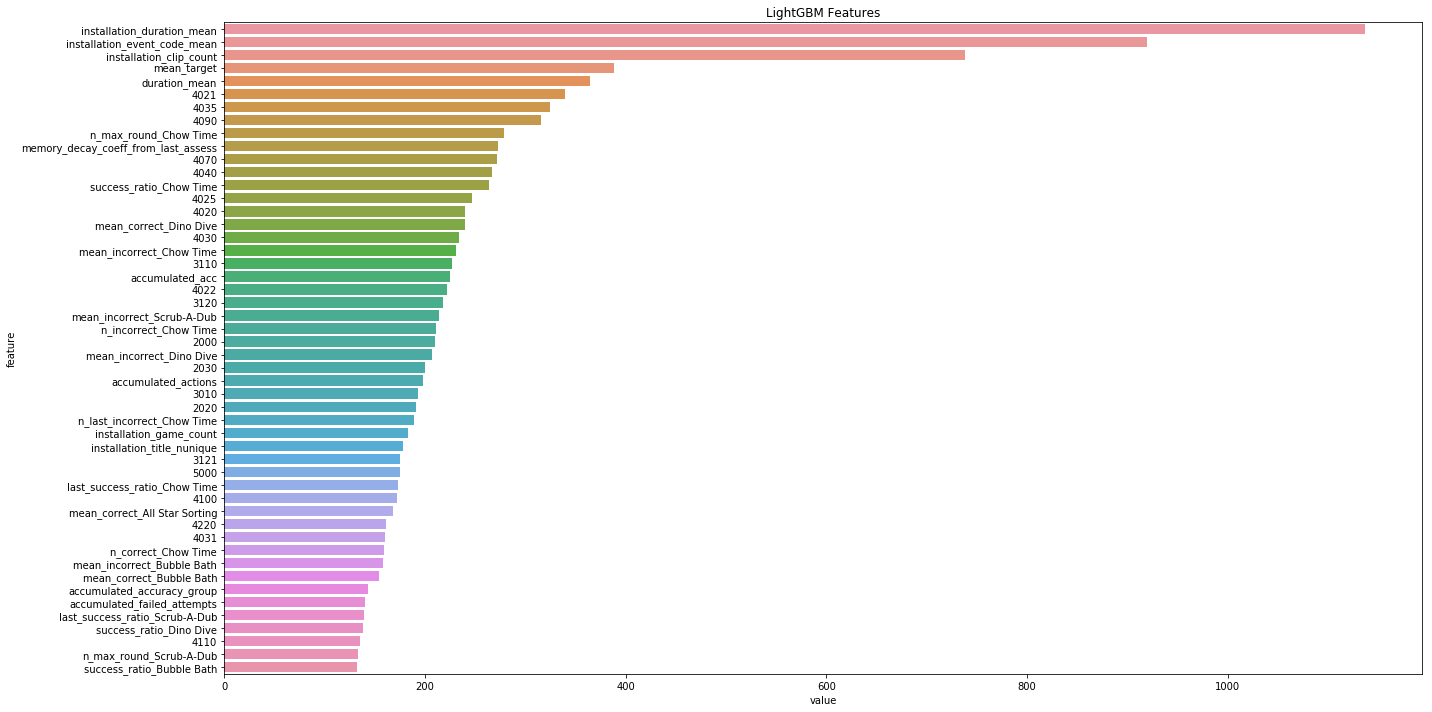

In [26]:
logging.info("Adversarial Validation")
train_adv = x_train.copy()
test_adv = x_valid.copy()

train_adv["target"] = 0
test_adv["target"] = 1
groups_adv = np.concatenate([groups, groups_valid])
train_test_adv = pd.concat([train_adv, test_adv], axis=0,
                           sort=False).reset_index(drop=True)

train_test_adv["group"] = groups_adv
splits = get_validation(train_test_adv, merged_config)
train_test_adv.drop("group", axis=1, inplace=True)

aucs = []
importance = np.zeros(len(cols))
for fold, (trn_idx, val_idx) in enumerate(splits):
    print("=" * 20)
    print(f"Fold: {fold}")
    print("=" * 20)

    x_train_adv = train_test_adv.loc[trn_idx, cols]
    y_train_adv = train_test_adv.loc[trn_idx, "target"]
    x_val_adv = train_test_adv.loc[val_idx, cols]
    y_val_adv = train_test_adv.loc[val_idx, "target"]

    train_lgb = lgb.Dataset(x_train_adv, label=y_train_adv)
    valid_lgb = lgb.Dataset(x_val_adv, label=y_val_adv)

    model_params = merged_config["av"]["model_params"]
    train_params = merged_config["av"]["train_params"]
    clf = lgb.train(
        model_params,
        train_lgb,
        valid_sets=[train_lgb, valid_lgb],
        valid_names=["train", "valid"],
        **train_params)

    aucs.append(clf.best_score)
    importance += clf.feature_importance(
        importance_type="gain") / len(splits)

# Check the feature importance
feature_imp = pd.DataFrame(
    sorted(zip(importance, cols)), columns=["value", "feature"])

plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("LightGBM Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_adv.png")

merged_config["av_result"] = dict()
merged_config["av_result"]["score"] = dict()
for i, auc in enumerate(aucs):
    merged_config["av_result"]["score"][f"fold{i}"] = auc

merged_config["av_result"]["feature_importances"] = \
    feature_imp.set_index("feature").sort_values(
        by="value",
        ascending=False
    ).to_dict()["value"]

### Train model

#### CatBoost model 

+++++++++++++++++++++++++
seed: 123
+++++++++++++++++++++++++
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 271ms	remaining: 27m 8s
100:	learn: 0.5774543	test: 0.5459561	best: 0.5476452 (91)	total: 21.5s	remaining: 20m 53s
200:	learn: 0.6109568	test: 0.5729667	best: 0.5746680 (157)	total: 42.9s	remaining: 20m 37s
300:	learn: 0.6182268	test: 0.5848271	best: 0.5852562 (297)	total: 1m 7s	remaining: 21m 14s
400:	learn: 0.6286670	test: 0.5830460	best: 0.5858514 (386)	total: 1m 32s	remaining: 21m 32s
500:	learn: 0.6394194	test: 0.5869902	best: 0.5881921 (427)	total: 1m 57s	remaining: 21m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5881920607
bestIteration = 427

Shrink model to first 428 iterations.
0:	learn: 0.0000000	test: 0.0000000	best: 0.0000000 (0)	total: 237ms	remaining: 23m 44s
100:	learn: 0.5778909	test: 0.5448752	best: 0.5459228 (99)	total: 24.8s	remaining: 24m 6s
200:	learn: 0.6091531	test: 0.5715274	best: 0.5740862 (175)	total: 48.8s	

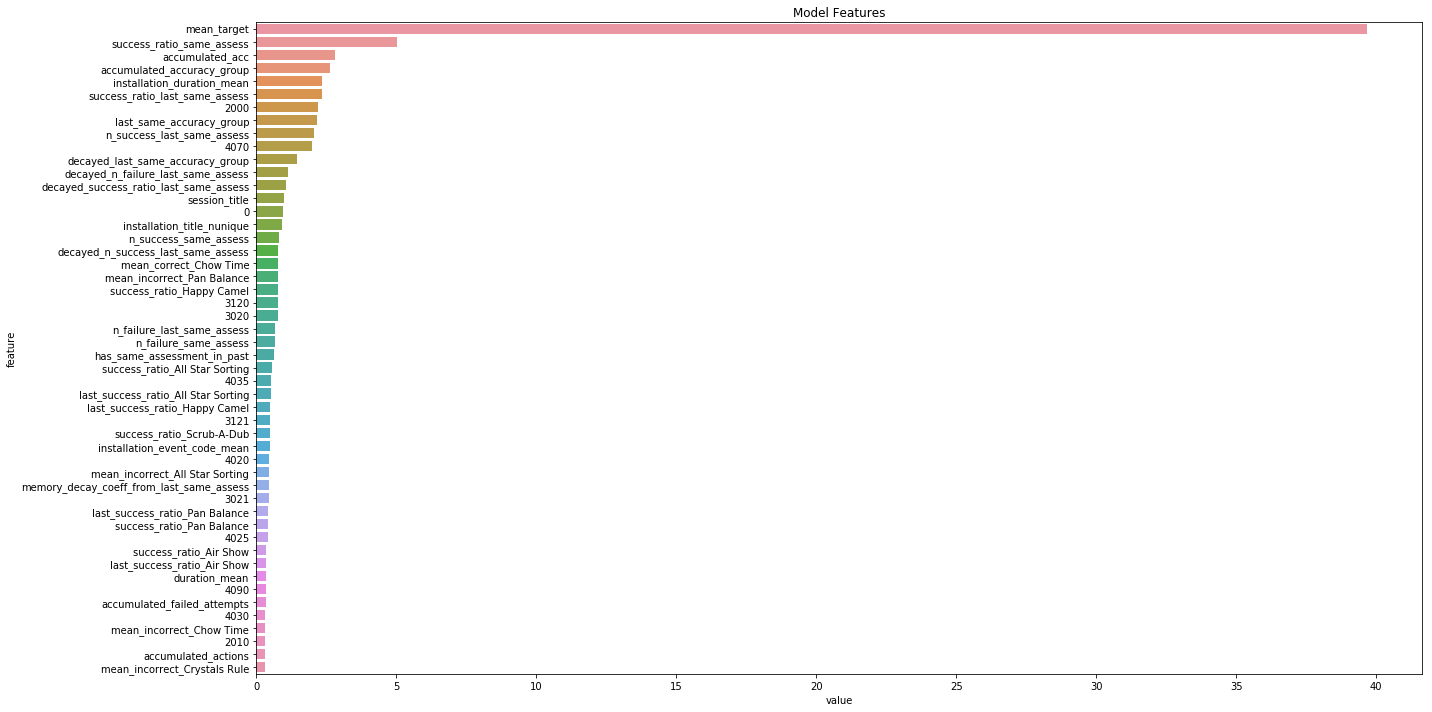

In [27]:
logging.info("Train model")
logging.info("CatBoost model")

model = get_model(cat_config)

avg_oof_preds = np.zeros(len(x_train))
avg_test_preds = np.zeros(len(x_test))
avg_valid_preds = np.zeros(len(x_valid))

importances = pd.DataFrame(index=cols)

seed_sets = [123, 456, 789, 101, 215]

for seed in seed_sets:
    print("+" * 25)
    print(f"seed: {seed}")
    print("+" * 25)
    
    cat_config["model"]["model_params"]["random_seed"] = seed
    
    cat_config["val"]["params"]["random_state"] = seed
    
    # get folds
    x_train["group"] = groups
    splits = get_validation(x_train, cat_config)
    x_train.drop("group", axis=1, inplace=True)
    
    _, _, _, _, feature_importance, eval_results = model.cv(
        y_train,
        x_train[cols],
        x_test[cols],
        y_valid,
        x_valid[cols],
        feature_name=cols,
        folds_ids=splits,
        config=cat_config,
        log=True)
    avg_oof_preds += model.raw_oof_preds / (len(seed_sets) * 2)
    avg_test_preds += model.raw_test_preds / (len(seed_sets) * 2)
    avg_valid_preds += model.raw_valid_preds / (len(seed_sets) * 2)
    
    cat_config[f"eval_results_seed{seed}"] = dict()
    for k, v in eval_results.items():
        cat_config[f"eval_results_seed{seed}"][k] = v
        
    feature_importance = feature_importance.to_frame().rename(
        columns={0: f"seed{seed}"})
    importances = importances.join(feature_importance, how="inner")
    
feature_imp = importances.mean(axis=1).reset_index().rename(
    columns={
        "index": "feature",
        0: "value"
    })

plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("Model Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_Cat.png")

#### LGBM model

+++++++++++++++++++++++++
seed: 387
+++++++++++++++++++++++++
Training until validation scores don't improve for 100 rounds
[100]	data_from_test's rmse: 0.343469	data_from_test's qwk: 0.541041	data_from_train's rmse: 0.341859	data_from_train's qwk: 0.566103
[200]	data_from_test's rmse: 0.328728	data_from_test's qwk: 0.577949	data_from_train's rmse: 0.324903	data_from_train's qwk: 0.613037
[300]	data_from_test's rmse: 0.326496	data_from_test's qwk: 0.58323	data_from_train's rmse: 0.320946	data_from_train's qwk: 0.617411
Early stopping, best iteration is:
[241]	data_from_test's rmse: 0.327161	data_from_test's qwk: 0.583418	data_from_train's rmse: 0.322502	data_from_train's qwk: 0.619028
Training until validation scores don't improve for 100 rounds
[100]	data_from_test's rmse: 0.341877	data_from_test's qwk: 0.553701	data_from_train's rmse: 0.349806	data_from_train's qwk: 0.596107
[200]	data_from_test's rmse: 0.327749	data_from_test's qwk: 0.585251	data_from_train's rmse: 0.330978	data_fro

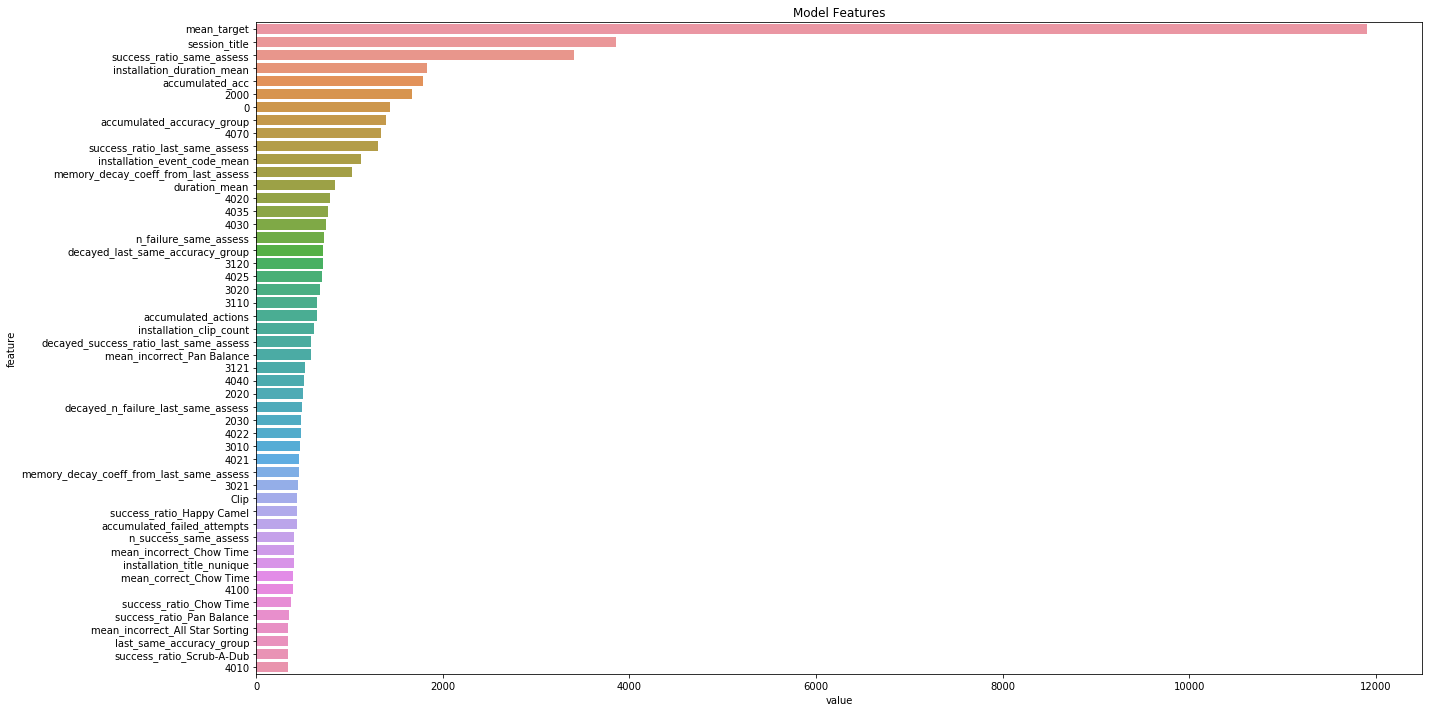

In [28]:
logging.info("Train model")

model = get_model(lgb_config)

importances = pd.DataFrame(index=cols)

seed_sets = [387, 289, 908, 634, 445]
for seed in seed_sets:
    print("+" * 25)
    print(f"seed: {seed}")
    print("+" * 25)
    
    lgb_config["model"]["model_params"]["seed"] = seed
    lgb_config["model"]["model_params"]["drop_seed"] = seed
    lgb_config["model"]["model_params"]["bagging_seed"] = seed
    lgb_config["model"]["model_params"]["feature_fraction_seed"] = seed
    
    lgb_config["val"]["params"]["random_state"] = seed
    
    # get folds
    x_train["group"] = groups
    splits = get_validation(x_train, lgb_config)
    x_train.drop("group", axis=1, inplace=True)
    
    _, _, _, _, feature_importance, eval_results = model.cv(
        y_train,
        x_train[cols],
        x_test[cols],
        y_valid,
        x_valid[cols],
        feature_name=cols,
        folds_ids=splits,
        config=lgb_config,
        log=True)
    avg_oof_preds += model.raw_oof_preds / (len(seed_sets) * 2)
    avg_test_preds += model.raw_test_preds / (len(seed_sets) * 2)
    avg_valid_preds += model.raw_valid_preds / (len(seed_sets) * 2)
    
    lgb_config[f"eval_results_seed{seed}"] = dict()
    for k, v in eval_results.items():
        lgb_config[f"eval_results_seed{seed}"][k] = v
        
    feature_importance = feature_importance.to_frame().rename(
        columns={0: f"seed{seed}"})
    importances = importances.join(feature_importance, how="inner")
    
feature_imp = importances.mean(axis=1).reset_index().rename(
    columns={
        "index": "feature",
        0: "value"
    })

plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("Model Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_LGB.png")

### Save

In [29]:
save_path = output_dir / "output.json"
save_json(merged_config, save_path)

### Ensemble

In [30]:
OptR = OptimizedRounder(n_classwise=20, n_overall=20)
OptR.fit(avg_oof_preds, y_train)

oof_preds_optimized = OptR.predict(avg_oof_preds)
test_preds_optimized = OptR.predict(avg_test_preds)
valid_preds_optimized = OptR.predict(avg_valid_preds)

oof_score = calc_metric(oof_preds_optimized, y_train)
print(f"Optimized OOF QWK: {oof_score:.4f}")
valid_score = calc_metric(valid_preds_optimized, y_valid)
print(f"Optimized valid QWK: {valid_score:.4f}")

Optimized OOF QWK: 0.6126
Optimized valid QWK: 0.5899


Normalized confusion matrix
[[0.56490896 0.20406716 0.14991724 0.08110664]
 [0.2185815  0.28535877 0.29448362 0.20157611]
 [0.08888889 0.15873016 0.34240363 0.40997732]
 [0.03369135 0.08976823 0.25664217 0.61989825]]
Normalized confusion matrix
[[0.55238095 0.18571429 0.17380952 0.08809524]
 [0.2        0.25283019 0.30566038 0.24150943]
 [0.07438017 0.1322314  0.30165289 0.49173554]
 [0.03391384 0.08432631 0.24747938 0.63428048]]


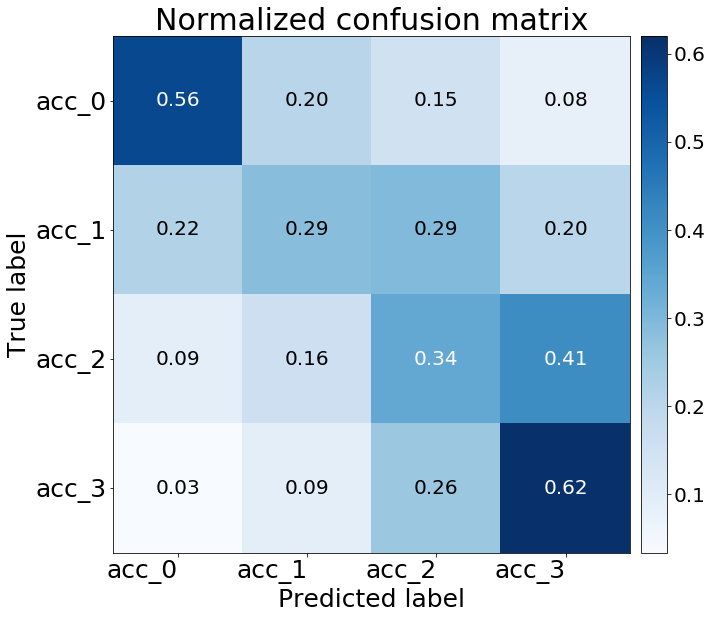

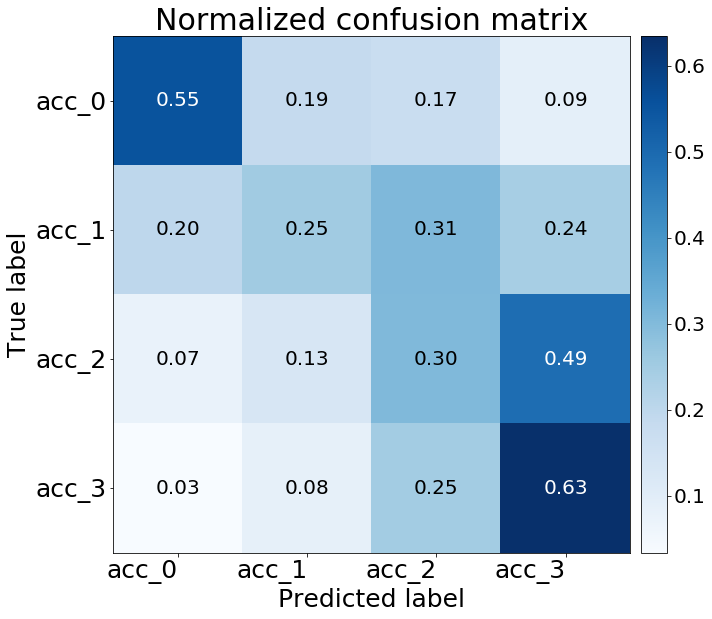

In [31]:
# Confusion Matrix
plot_confusion_matrix(
    y_train,
    oof_preds_optimized,
    classes=np.array(["acc_0", "acc_1", "acc_2", "acc_3"]),
    normalize=True,
    save_path=output_dir / "confusion_matrix_oof.png")
plot_confusion_matrix(
    y_valid,
    valid_preds_optimized,
    classes=np.array(["acc_0", "acc_1", "acc_2", "acc_3"]),
    normalize=True,
    save_path=output_dir / "confusion_matrix_valid.png")

### Make submission

In [32]:
sample_submission = pd.read_csv(
    input_dir / "sample_submission.csv")
sample_submission["accuracy_group"] = test_preds_optimized
sample_submission.to_csv('submission.csv', index=None)
sample_submission.head()

,installation_id,accuracy_group
0,00abaee7,2
1,01242218,3
2,017c5718,2
3,01a44906,3
4,01bc6cb6,2
